<h1> Lab 7: Recurrent Network Architectures </h1>

<h4> Adam Ashcraft, Maya Muralidhar, Nora Potenti, Michael Watts </h4>

<h1> 1.0 Preparation </h1>

<h2> 1.1 Business Understanding </h2>

Our data set is a collection of emails 500,000 emails from over 150 Enron Employees. Enron was part of a massive scandal involving the hiding of debt through various loopholes from stockholders. When the debt was finally revealed, the stock price tanked and the company become virtually worthless. Due to this large loss, many stockholders decided to sue Enron. The tool we are creating will use email data to identify the original writer of the email. This tool could then be taken to things such as inner office memos or secretive forms of communication were the original writer may have avoiding signing his name, such as orders to hide debt, and identify the original author. This will help companies like Enron to assign specific blame to those individuals who encouraged the hiding of debt. Since the scandal was companywide, it is fair to assume those ordering the debt obfuscation must be in contact with the entire company. So, for the sake of our tool, we will focus on the top 5 email senders, as they would have the most overall communication within Enron. 

<hr>
Kaggle Data Set: https://www.kaggle.com/wcukierski/enron-email-dataset/home <br>
Enron Scandal Information: https://en.wikipedia.org/wiki/Enron_scandal

<h2> 1.2 Data Preparation </h2>

Let’s begin by looking at the data itself.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pickle
import warnings
from sklearn.metrics import accuracy_score
from keras.models import load_model
from sklearn import metrics as mt

In [2]:
emails_df = pd.read_csv("data/emails.csv")
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


We will begin by extracting information about the names of the senders of emails. This will help us later with dividing the emails based on the top 5 senders.


In [3]:
#print(emails_df['message'][8])
import re
def filter_fn(item):
    if item == '' or item == ' ':
        return False
    return True
def parse_email(item):
    findall = re.findall("From: .+.com\n", item)
    if len(findall) > 0:
        return findall[0].split(' ')[1].strip()
    else:
        return None
#print('\n'.join(list(filter(filter_fn, emails_df['message'][x].split('X-FileName:')[1].split('\n')))[1:]))
#emails_df['message'] = emails_df['message'].apply(lambda x: '\n'.join(list(filter(filter_fn, x.split('X-FileName:')[1].split('\n')))[1:]))
emails_df['source'] = emails_df['file'].apply(lambda x: x.split('/', 1)[0])
emails_df['source'].value_counts()[0:5]

kaminski-v    28465
dasovich-j    28234
kean-s        25351
mann-k        23381
jones-t       19950
Name: source, dtype: int64

In [4]:
top_five_sources = emails_df['source'].value_counts()[0:5].index.tolist() # Display top 5 email senders
emails_df = emails_df[emails_df['source'].isin(top_five_sources)].reset_index()
sources = emails_df['source'].unique()
source_dict = dict(zip(sources, range(len(sources))))
emails_df = emails_df.applymap(lambda s: source_dict.get(s) if s in source_dict else s)
emails_df['source_email'] = emails_df['message'].apply(lambda x: parse_email(x))
emails_df['source_email'].value_counts()[0:5]

kay.mann@enron.com          16658
vince.kaminski@enron.com    14335
jeff.dasovich@enron.com     10874
tana.jones@enron.com         7960
steven.kean@enron.com        6709
Name: source_email, dtype: int64

These are the names of the top 5 email writers in the data set. Now we will remove any emails not from one of these 5 and encode these 5 names into 5 classes.


In [5]:
def remove_names(input_str, name_list):
    filename = '' if len(re.findall("(?<=X-FileName: )\w+\.[\w]{3}", input_str)) == 0 else re.findall("(?<=X-FileName: )\w+\.[\w]{3}", input_str)[0] 
    if filename is not '':
        input_str = input_str.split(filename)[-1]
    for name in name_list:
        input_str = input_str.replace(name[0], '')
        input_str = input_str.replace(name[1], '')
    return input_str
top_emails = emails_df['source_email'].value_counts()[0:5].index.tolist()
parsed_names = [(x.split('@')[0].split('.')[0].capitalize(), x.split('@')[0].split('.')[1].capitalize()) for x in top_emails]
#emails_df['message'] = emails_df['message'].apply(lambda x: remove_names(x, parsed_names))

Finally, we will use a tokenizer and padding in order to make the input into the network a unified shape. We will set a size of 500 tokens, padding any emails too short and cutting off any emails too long.


In [6]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
NUM_TOP_WORDS = None
MAX_ART_LEN = 300 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(emails_df['message'])
sequences = tokenizer.texts_to_sequences(emails_df['message'])

/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = emails_df['source']

print('Shape of data tensor:', X.shape)
#print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 455561 unique tokens. Distilled to 455561 top words.
Shape of data tensor: (125381, 300)
455555


In [8]:
print("Number of emails: ", np.size(X))

Number of emails:  37614300


<h2> 1.3 Evaluation Criteria </h2>

For the purposes of this lab, we will be using recall as the evaluation criteria. Recall has a focus on lowering false negatives. In this scenario, this is a document written by user A being classified as having been written by someone else. This means this document would be ignored and not used as part of case against user A. This limits the evidence available to convict a guilty man. While false negatives are important as they assign guilty evidence to an innocent man, our primary focus is capturing guilty parties from this scandal rather than proving innocent ones and not letting them escape without suffering for the consequences of their actions.  


<h2> 1.4 Data Division </h2>

Due to our large data set size of over 37,000,000 emails, we will be using 80/20 holdout in order to all us to test our data in an efficient manner. 


In [9]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify=emails_df['source'], 
                                                            random_state=42)
y_train_ohe = keras.utils.to_categorical(y_train)
y_test_ohe = keras.utils.to_categorical(y_test)
NUM_CLASSES = 5
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(100304, 300) (100304, 5)
[22587. 15960. 22772. 20280. 18705.]


<h1> 2.0 Modeling </h1>

<h2> 2.1 Simple, LSTM, and GRU </h2>

In [10]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    rnns.append(rnn)

======= simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 514s 5ms/step - loss: 0.4040 - acc: 0.8271 - val_loss: 0.2749 - val_acc: 0.8860
Epoch 2/3
100304/100304 [==============================] - 507s 5ms/step - loss: 0.2378 - acc: 0.9024 - val_loss: 0.1797 - val_acc: 0.9289
Epoch 3/3
100304/100304 [==============================] - 514s 5ms/step - loss: 0.1769 - acc: 0.9315 - val_loss: 0.1478 - val_acc: 0.9435


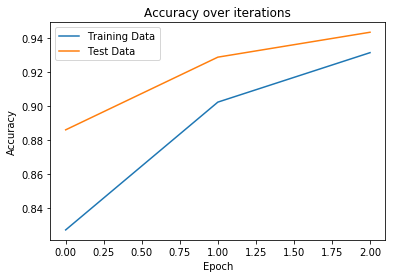

======= lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 877s 9ms/step - loss: 0.1672 - acc: 0.9358 - val_loss: 0.0853 - val_acc: 0.9704
Epoch 2/3
100304/100304 [==============================] - 877s 9ms/step - loss: 0.0694 - acc: 0.9748 - val_loss: 0.0521 - val_acc: 0.9810
Epoch 3/3
100304/100304 [==============================] - 883s 9ms/step - loss: 0.0469 - acc: 0.9827 - val_loss: 0.0416 - val_acc: 0.9842


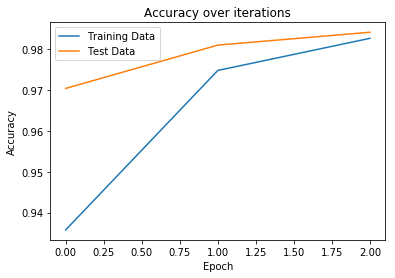

======= gru ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 769s 8ms/step - loss: 0.1060 - acc: 0.9594 - val_loss: 0.0373 - val_acc: 0.9855
Epoch 2/3
100304/100304 [==============================] - 774s 8ms/step - loss: 0.0329 - acc: 0.9875 - val_loss: 0.0313 - val_acc: 0.9877
Epoch 3/3
100304/100304 [==============================] - 778s 8ms/step - loss: 0.0264 - acc: 0.9901 - val_loss: 0.0289 - val_acc: 0.9890


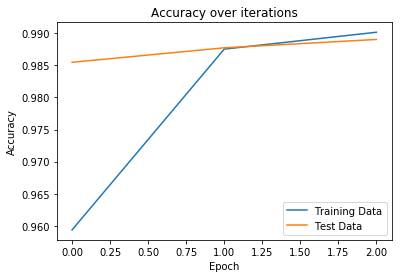

In [30]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    info = rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()

In [31]:
for count, rnn in enumerate(rnns):
    name = 'large_data/' + str(count) + '.h5'
    rnn.save(name)

<h2> 2.2 Hyperparameter Tuning </h2>

First, we will double the rate of drop out to see how this affects the RNN’s ability to memorize and learn from out data.


In [32]:
EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50, dropout=0.4, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    rnns.append(rnn)

======= simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 515s 5ms/step - loss: 0.4314 - acc: 0.8104 - val_loss: 0.3147 - val_acc: 0.8674
Epoch 2/3
100304/100304 [==============================] - 514s 5ms/step - loss: 0.2828 - acc: 0.8841 - val_loss: 0.2209 - val_acc: 0.9096
Epoch 3/3
100304/100304 [==============================] - 520s 5ms/step - loss: 0.2158 - acc: 0.9136 - val_loss: 0.1678 - val_acc: 0.9348


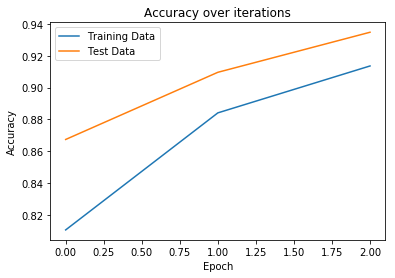

======= lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 887s 9ms/step - loss: 0.1810 - acc: 0.9292 - val_loss: 0.0847 - val_acc: 0.9701
Epoch 2/3
100304/100304 [==============================] - 885s 9ms/step - loss: 0.0735 - acc: 0.9735 - val_loss: 0.0556 - val_acc: 0.9792
Epoch 3/3
100304/100304 [==============================] - 890s 9ms/step - loss: 0.0525 - acc: 0.9804 - val_loss: 0.0433 - val_acc: 0.9834


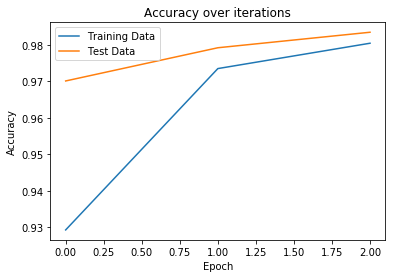

======= gru ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 779s 8ms/step - loss: 0.1139 - acc: 0.9559 - val_loss: 0.0415 - val_acc: 0.9835
Epoch 2/3
100304/100304 [==============================] - 783s 8ms/step - loss: 0.0381 - acc: 0.9851 - val_loss: 0.0350 - val_acc: 0.9865
Epoch 3/3
100304/100304 [==============================] - 789s 8ms/step - loss: 0.0307 - acc: 0.9883 - val_loss: 0.0314 - val_acc: 0.9879


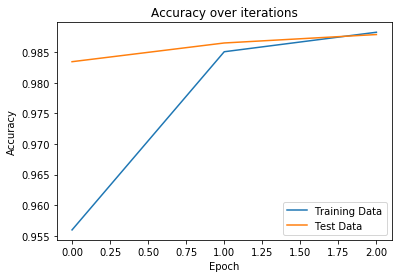

In [33]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    info = rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()

In [34]:
for count, rnn in enumerate(rnns):
    name = 'large_data/' + str((count + 3)) + '.h5'
    rnn.save(name)

Next, we will double the embedding space to see how this affects our RNN’s performance. 


In [35]:
EMBED_SIZE = 100
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(100, dropout=0.4, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    rnns.append(rnn)

======= simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 1126s 11ms/step - loss: 0.3923 - acc: 0.8326 - val_loss: 0.2952 - val_acc: 0.8789
Epoch 2/3
100304/100304 [==============================] - 1122s 11ms/step - loss: 0.2543 - acc: 0.8961 - val_loss: 0.2043 - val_acc: 0.9150
Epoch 3/3
100304/100304 [==============================] - 1135s 11ms/step - loss: 0.1927 - acc: 0.9241 - val_loss: 0.1716 - val_acc: 0.9335


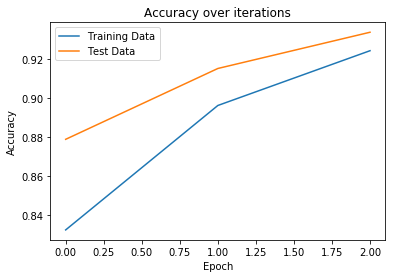

======= lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 1568s 16ms/step - loss: 0.1499 - acc: 0.9419 - val_loss: 0.0735 - val_acc: 0.9733
Epoch 2/3
100304/100304 [==============================] - 1585s 16ms/step - loss: 0.0629 - acc: 0.9763 - val_loss: 0.0566 - val_acc: 0.9774
Epoch 3/3
100304/100304 [==============================] - 1591s 16ms/step - loss: 0.0446 - acc: 0.9827 - val_loss: 0.0391 - val_acc: 0.9849


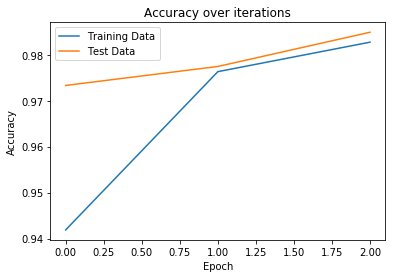

======= gru ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 1438s 14ms/step - loss: 0.0677 - acc: 0.9741 - val_loss: 0.0384 - val_acc: 0.9847
Epoch 2/3
100304/100304 [==============================] - 1448s 14ms/step - loss: 0.0300 - acc: 0.9884 - val_loss: 0.0315 - val_acc: 0.9877
Epoch 3/3
100304/100304 [==============================] - 1461s 15ms/step - loss: 0.0255 - acc: 0.9905 - val_loss: 0.0287 - val_acc: 0.9886


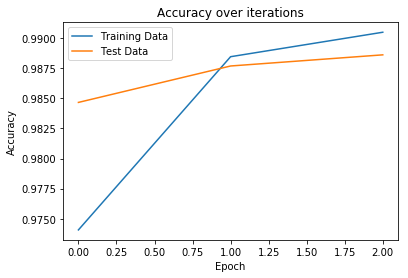

In [36]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    info = rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()

In [37]:
for count, rnn in enumerate(rnns):
    name = 'large_data/' + str((count + 3 + 3)) + '.h5'
    rnn.save(name)

Finally, we will attempt to double the number of epochs to see how this affects performance. 


In [11]:
EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    rnns.append(rnn)

======= simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/6
100304/100304 [==============================] - 500s 5ms/step - loss: 0.3923 - acc: 0.8329 - val_loss: 0.2710 - val_acc: 0.8871
Epoch 2/6
100304/100304 [==============================] - 502s 5ms/step - loss: 0.2364 - acc: 0.9036 - val_loss: 0.1807 - val_acc: 0.9273
Epoch 3/6
100304/100304 [==============================] - 507s 5ms/step - loss: 0.1774 - acc: 0.9307 - val_loss: 0.1538 - val_acc: 0.9408
Epoch 4/6
100304/100304 [==============================] - 511s 5ms/step - loss: 0.1462 - acc: 0.9447 - val_loss: 0.1370 - val_acc: 0.9480
Epoch 5/6
100304/100304 [==============================] - 516s 5ms/step - loss: 0.1299 - acc: 0.9517 - val_loss: 0.1351 - val_acc: 0.9508
Epoch 6/6
100304/100304 [==============================] - 520s 5ms/step - loss: 0.1207 - acc: 0.9558 - val_loss: 0.1224 - val_acc: 0.9556


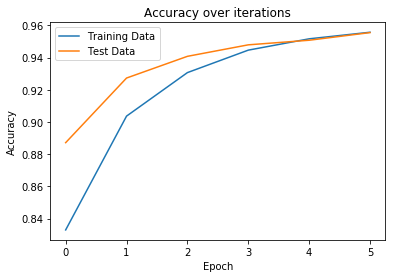

======= lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/6
100304/100304 [==============================] - 858s 9ms/step - loss: 0.1585 - acc: 0.9385 - val_loss: 0.0820 - val_acc: 0.9723
Epoch 2/6
100304/100304 [==============================] - 857s 9ms/step - loss: 0.0710 - acc: 0.9744 - val_loss: 0.0510 - val_acc: 0.9821
Epoch 3/6
100304/100304 [==============================] - 871s 9ms/step - loss: 0.0498 - acc: 0.9820 - val_loss: 0.0469 - val_acc: 0.9827
Epoch 4/6
100304/100304 [==============================] - 867s 9ms/step - loss: 0.0386 - acc: 0.9859 - val_loss: 0.0367 - val_acc: 0.9858
Epoch 5/6
100304/100304 [==============================] - 870s 9ms/step - loss: 0.0320 - acc: 0.9881 - val_loss: 0.0339 - val_acc: 0.9870
Epoch 6/6
100304/100304 [==============================] - 871s 9ms/step - loss: 0.0279 - acc: 0.9897 - val_loss: 0.0310 - val_acc: 0.9883


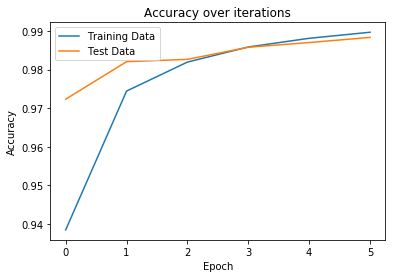

======= gru ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/6
100304/100304 [==============================] - 763s 8ms/step - loss: 0.0863 - acc: 0.9682 - val_loss: 0.0328 - val_acc: 0.9876
Epoch 2/6
100304/100304 [==============================] - 766s 8ms/step - loss: 0.0278 - acc: 0.9896 - val_loss: 0.0302 - val_acc: 0.9885
Epoch 3/6
100304/100304 [==============================] - 768s 8ms/step - loss: 0.0237 - acc: 0.9911 - val_loss: 0.0275 - val_acc: 0.9900
Epoch 4/6
100304/100304 [==============================] - 775s 8ms/step - loss: 0.0215 - acc: 0.9919 - val_loss: 0.0260 - val_acc: 0.9904
Epoch 5/6
100304/100304 [==============================] - 780s 8ms/step - loss: 0.0200 - acc: 0.9925 - val_loss: 0.0264 - val_acc: 0.9899
Epoch 6/6
100304/100304 [==============================] - 785s 8ms/step - loss: 0.0190 - acc: 0.9931 - val_loss: 0.0253 - val_acc: 0.9909


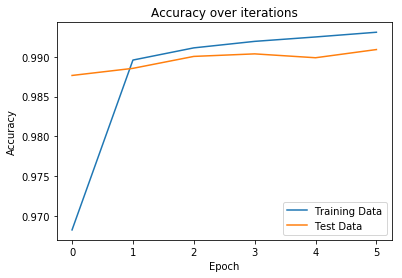

In [12]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    info = rnn.fit(X_train, y_train_ohe, epochs=6, batch_size=64, validation_data=(X_test, y_test_ohe))
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()

In [13]:
for count, rnn in enumerate(rnns):
    name = 'large_data/' + str((count + 3 + 3 + 3)) + '.h5'
    rnn.save(name)

<h2> 2.3 Added Layers </h2>

Our highest performance without risk of overfitting came from the use of an LSTM with three epochs, a size 50 embedded space, and .2 dropout rate. So we will add another layer to this RNN and run it over the data again.


In [24]:
EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

for func in [ LSTM]:
    
    x = func(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(shared_embed)
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    rnns.append(rnn)

======= lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 1395s 14ms/step - loss: 0.2506 - acc: 0.8835 - val_loss: 0.1090 - val_acc: 0.9581
Epoch 2/3
100304/100304 [==============================] - 1393s 14ms/step - loss: 0.0897 - acc: 0.9676 - val_loss: 0.0608 - val_acc: 0.9786
Epoch 3/3
100304/100304 [==============================] - 1404s 14ms/step - loss: 0.0599 - acc: 0.9786 - val_loss: 0.0484 - val_acc: 0.9826


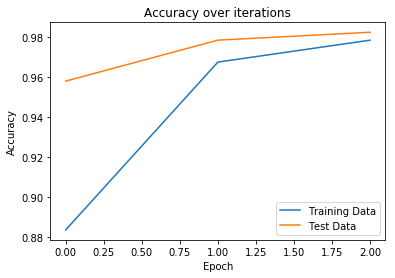

In [26]:
for rnn, name in zip(rnns,['lstm']):
    print('=======',name,'========')
    info = rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()

In [27]:
for count, rnn in enumerate(rnns):
    name = 'large_data/finalmodel' + str((count + 3 + 3 + 3 + 3)) + '.h5'
    rnn.save(name)

<hr>

In [14]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('Round 2 training,',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))

Round 2 training, simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 461s 5ms/step - loss: 0.1639 - acc: 0.9378 - val_loss: 0.1249 - val_acc: 0.9549
Epoch 2/3
100304/100304 [==============================] - 465s 5ms/step - loss: 0.1285 - acc: 0.9533 - val_loss: 0.1092 - val_acc: 0.9619
Epoch 3/3
100304/100304 [==============================] - 471s 5ms/step - loss: 0.1142 - acc: 0.9594 - val_loss: 0.0995 - val_acc: 0.9657
Round 2 training, lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 694s 7ms/step - loss: 0.0343 - acc: 0.9875 - val_loss: 0.0326 - val_acc: 0.9882
Epoch 2/3
100304/100304 [==============================] - 698s 7ms/step - loss: 0.0262 - acc: 0.9904 - val_loss: 0.0287 - val_acc: 0.9895
Epoch 3/3
100304/100304 [==============================] - 699s 7ms/step - loss: 0.0229 - acc: 0.9915 - val_loss: 0.0275 - val_acc: 0.990

Text(0.5,1,'RNN: 0.9762435947285554')

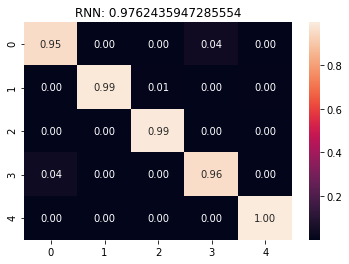

In [27]:
yhat_rnn = np.argmax(rnn.predict(X_test), axis=1)
f_rnn = mt.f1_score(y_test.values,yhat_rnn, average= 'weighted')
cm = mt.confusion_matrix(y_test.values,yhat_rnn)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('RNN: '+str(f_rnn))